In [2]:
#install required versions of libraries 
!pip install --quiet tensorflow-hub
!pip install --quiet seaborn
!pip install pyspellchecker

     |████████████████████████████████| 1.9 MB 505 kB/s eta 0:00:01


In [ ]:
#importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import defaultdict
import nltk
from nltk.corpus import stopwords

from nltk.util import ngrams
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer

import re
from spellchecker import SpellChecker

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
import itertools
import datetime
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Lambda, SpatialDropout1D, Dense, GRU
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam,Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers


from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adadelta

In [33]:
# Importing the dataset
train_dataset = pd.read_csv('train.csv')
test_dataset = pd.read_csv('test.csv')

In [34]:
train_dataset.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


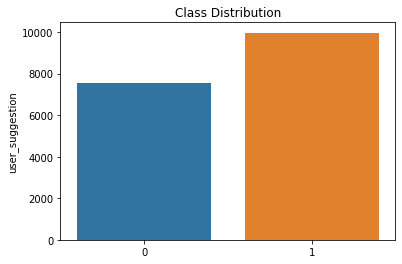

In [35]:
#class distribution
x=train_dataset.user_suggestion.value_counts()
sns.barplot(x.index,x)
plt.title('Class Distribution')
plt.show()

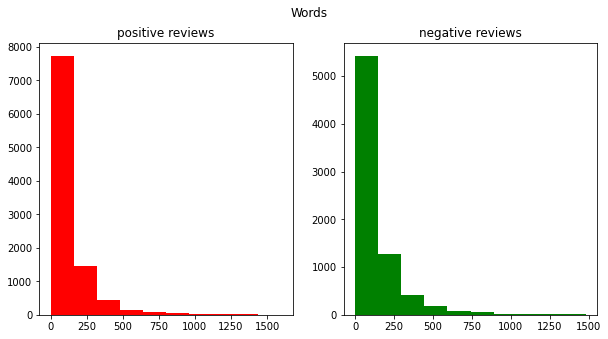

In [36]:
#word analysis
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_dataset[train_dataset['user_suggestion']==1]['user_review'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('positive reviews')
tweet_len=train_dataset[train_dataset['user_suggestion']==0]['user_review'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('negative reviews')
fig.suptitle('Words')
plt.show()

Text(0.5, 0.98, 'Average word length in each review')

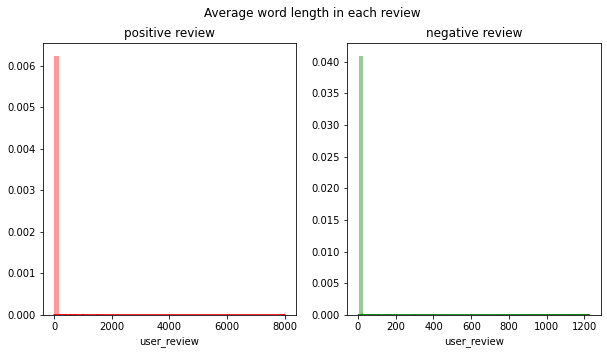

In [37]:
#Average word length
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train_dataset[train_dataset['user_suggestion']==1]['user_review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('positive review')
word=train_dataset[train_dataset['user_suggestion']==0]['user_review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('negative review')
fig.suptitle('Average word length in each review')

In [38]:
#create corpus
def create_corpus(target):
    corpus=[]
    
    for x in train_dataset[train_dataset['user_suggestion']==target]['user_review'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [39]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/suryanarayanan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<BarContainer object of 10 artists>

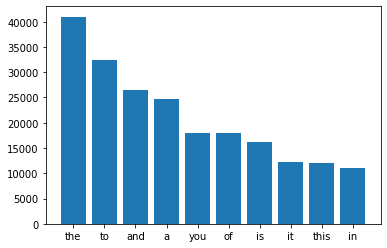

In [40]:
#analyze target=0
corpus=create_corpus(0)
stop=set(stopwords.words('english'))
dic=defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

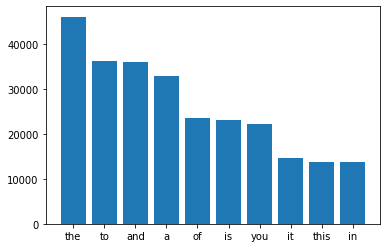

In [41]:
#analyze target=1
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 31 artists>

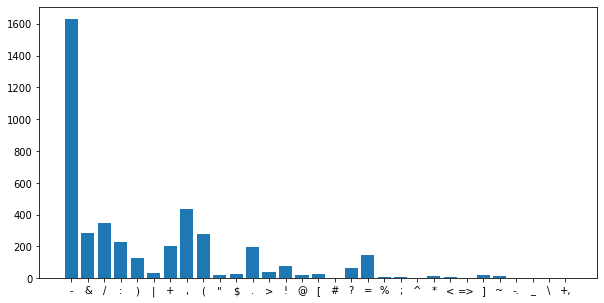

In [42]:
#analyze punctuations in target=1
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 31 artists>

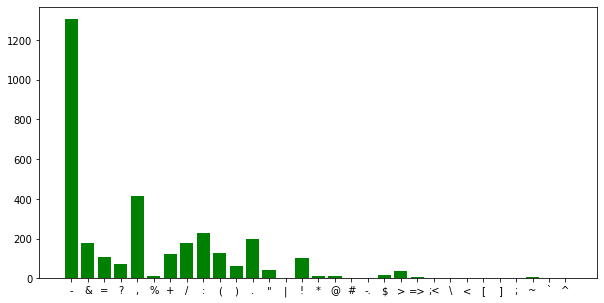

In [43]:
#analyze punctuations in target=0
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

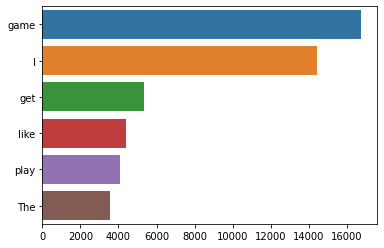

In [44]:
#Common Words other than stopwords
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

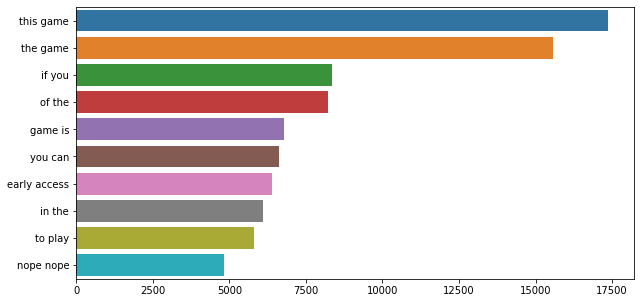

In [45]:
#ngram analysis
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(train_dataset['user_review'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [46]:
#Data Cleaning
#df=pd.concat([train_dataset,test_dataset])
#df.shape

example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

train_dataset['user_review']=train_dataset['user_review'].apply(lambda x : remove_URL(x))
test_dataset['user_review']=test_dataset['user_review'].apply(lambda x : remove_URL(x))

example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

print(remove_html(example))

train_dataset['user_review']=train_dataset['user_review'].apply(lambda x : remove_html(x))
test_dataset['user_review']=test_dataset['user_review'].apply(lambda x : remove_html(x))

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

train_dataset['user_review']=train_dataset['user_review'].apply(lambda x : remove_emoji(x))
test_dataset['user_review']=test_dataset['user_review'].apply(lambda x : remove_emoji(x))


def remove_punct(text):    
    punctuations = '¯™¥-♥#$%&:;\()+-<=>@[\\]^_`{|}~/¯( ͡° ͜ʖ ͡°) ͜ʖ° ͜ʖ ͡°ʖ ͡☉ ͡☉ ͡ ͡ ͡  ͡ ▌░╔╗║╔═╗'
    for p in punctuations:
        text = text.replace(p, ' ')
    text = re.sub(' +', ' ', text)
    return text

example="I am a #king"
print(remove_punct(example))

train_dataset['user_review']=train_dataset['user_review'].apply(lambda x : remove_punct(x))
test_dataset['user_review']=test_dataset['user_review'].apply(lambda x : remove_punct(x))

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

#train_dataset['text']=train_dataset['text'].apply(lambda x : correct_spellings(x))
#test_dataset['text']=test_dataset['text'].apply(lambda x : correct_spellings(x))

def clean(text):
    
    text = re.sub(" he's ", " he is ", text)
    text = re.sub(" there's ", " there is ", text)
    text = re.sub(" we're ", " we are ", text)
    text = re.sub("you'll", " you will ", text)

    text = re.sub(" that's ", " that is ", text)
    text = re.sub(" won't ", " will not ", text)
    text = re.sub(" they're ", " they are ", text)
    text = re.sub(" wan't ", " cannot ", text)
    text = re.sub(" wasn't ", " was not ", text)
    text = re.sub(" aren't ", " are not ", text)
    text = re.sub(" isn't ", " is not ", text)
    text = re.sub("haven't", " have not ", text)
    text = re.sub(" hasn't ", " has not ", text)
    text = re.sub(" there's ", " there is ", text)
    text = re.sub(" he's ", " he is ", text)
    text = re.sub(" it's ", " it is ", text)
    text = re.sub(" wou're ", " you are ", text)
    text = re.sub(" isnt ", " is not ", text)
    text = re.sub(" shouldn't ", " should not ", text)
    text = re.sub(" wouldn't ", " would not ", text)
    text = re.sub("i'm", " i am ", text)
    text = re.sub("i'm ", " i am ", text)
    text = re.sub(" im ", " i am ", text)
    text = re.sub(" youre ", " you are ", text)
    text = re.sub(" ive ", " i have ", text)
    text = re.sub(" cant ", " can not ", text)
    text = re.sub(" ive ", " i have ", text)
    text = re.sub(" dont ", " do not ", text)
    text = re.sub("doesnt", " does not ", text)
    text = re.sub(" thats ", " that is ", text)
    text = re.sub(" doesnt ", " does not ", text)
    text = re.sub(" don ‘ t ", " do not ", text) 
    text = re.sub(" i'll", " i will ", text)

    text = re.sub(" isn't ", " is not ", text)
    text = re.sub(" here's", " here is ", text)
    text = re.sub(" you've", " you have ", text)
    text = re.sub(" we're", " we are ", text)
    text = re.sub(" what's", " what is ", text)
    text = re.sub(" couldn't", "could not", text)
    text = re.sub(" we've", " we have ", text)
    text = re.sub(" who's", " who is ", text)
    text = re.sub(" y'all", " you all ", text)
    text = re.sub(" would've", " would have ", text)
    text = re.sub(" it'll", " it will ", text)
    text = re.sub(" we'll", " we will ", text)
    text = re.sub(" we've", " we have ", text)
    text = re.sub(" he'll", " he will ", text)
    text = re.sub(" y'all", " you all ", text)
    text = re.sub(" weren't", " were not ", text)
    text = re.sub(" didn't", " did not ", text)
    text = re.sub(" they'll", " they will ", text)
    text = re.sub(" they'd", " they would ", text)
    text = re.sub(" they've", " they have ", text)
    text = re.sub(" i'd", " i would ", text)
    text = re.sub(" should've", " should have ", text)
    text = re.sub(" where's", " where is ", text)
    text = re.sub(" we'd", " we would ", text)
    text = re.sub(" weren't", " were not ", text)
    text = re.sub(" they're", " they are ", text)
    text = re.sub(" let's", " let us ", text)
    text = re.sub(" it's", " it is ", text)
    text = re.sub(" can't", " cannot ", text)
    text = re.sub(" don't", " do not ", text)
    text = re.sub(" you're", " you are ", text)
    text = re.sub(" i've", " i have ", text)
    text = re.sub(" that's", " that is ", text)
    text = re.sub(" doesn't", " does not ", text)
    text = re.sub(" i'd", " i would ", text)
    text = re.sub(" didn't", " did not ", text)
    text = re.sub(" ain't", " am not ", text)
    text = re.sub(" you'll", " you will ", text)
    text = re.sub(" i've", " i have ", text)
    text = re.sub(" don't", " do not ", text)
    text = re.sub("i'll", " i will ", text)
    text = re.sub(" i'd", " i would ", text)
    text = re.sub(" let's", " let us ", text)
    text = re.sub(" you'd", " you would ", text)
    text = re.sub(" it's", " it is ", text)
    text = re.sub(" ain't", " am not ", text)
    text = re.sub(" could've", " could have ", text)
    text = re.sub("youve", " you have ", text)  
    text = re.sub("i'm", " i am ", text)   

            
#     Character entity references
    text = re.sub("&gt;", ">", text)
    text = re.sub("&lt;", "<", text)
    text = re.sub("&amp;", "&", text)
    
    return text

train_dataset['user_review']=train_dataset['user_review'].apply(lambda x : clean(x))
test_dataset['user_review']=test_dataset['user_review'].apply(lambda x : clean(x))




Real or Fake
Kaggle 
getting started

I am a king


In [48]:
test_dataset.head()

,review_id,title,year,user_review
0,1603,Counter-Strike: Global Offensive,2015.0,"Nice graphics, new maps, weapons and models. B..."
1,1604,Counter-Strike: Global Offensive,2018.0,I would not recommend getting into this at its...
2,1605,Counter-Strike: Global Offensive,2018.0,Edit 11 12 18I have tried playing CS GO recent...
3,1606,Counter-Strike: Global Offensive,2015.0,The game is great. But the community is the wo...
4,1607,Counter-Strike: Global Offensive,2015.0,I thank TrulyRazor for buying this for me a lo...


In [ ]:
#test google encoder in TF2
hub_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
embed = hub.load(hub_url)

In [ ]:
X = train_dataset.iloc[:, 3].values
y = train_dataset.iloc[:, 4].values

In [ ]:
#splitting into test & train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
#X_test = test_dataset.iloc[:, 3].values

In [ ]:
len(X_test)

3499

In [ ]:
X_train_embed = []

In [ ]:
for i in range(0,10000):
    temp = embed([X_train[i]])
    X_train_embed.append(temp)
    #temp = [temp]
    #temp = np.asarray(temp)
    #X_train_embed=np.append(X_train_embed,temp,axis=0)

In [ ]:
len(X_train_embed)

10000

In [ ]:
X_test_embed = []

In [ ]:
for i in range(0,2000):
    temp = embed([X_test[i]])
    X_test_embed.append(temp)
    #temp = [temp]
    #temp = np.asarray(temp)
    #X_test_embed=np.append(X_test_embed,temp,axis=0)

In [ ]:
temp1 = y_train[0:10000]
temp2 = y_test[0:2000]

In [ ]:
temp1 = np.asarray(temp1)
temp2 = np.asarray(temp2)

In [ ]:
X_train_embed = np.asarray(X_train_embed)
X_test_embed = np.asarray(X_test_embed)

In [ ]:
#Building a model
model1 = Sequential()

In [ ]:
model1.add(Input(shape=(1,512), dtype='float32'))
model1.add(SpatialDropout1D(0.2))
model1.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(1, activation='sigmoid'))

optimzer=Adam(learning_rate=1e-5)

model1.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spatial_dropout1d_1 (Spatial (None, 1, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                147712    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 147,777
Trainable params: 147,777
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from time import time
import datetime
n_epoch = 100

In [ ]:
training_start_time = time()

trained = model1.fit(X_train_embed, temp1, batch_size=64, epochs=n_epoch)

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6909 - accuracy: 0.5691
Epoch 2/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6868 - accuracy: 0.5939
Epoch 3/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6827 - accuracy: 0.5799
Epoch 4/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6787 - accuracy: 0.5767
Epoch 5/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6745 - accuracy: 0.5756
Epoch 6/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6704 - accuracy: 0.5763
Epoch 7/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6659 - accuracy: 0.5777
Epoch 8/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6614 - accuracy: 0.5796
Epoch 9/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6574 - accuracy: 0.5819
Epoch 10/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6526 - accura

In [49]:
model2 = Sequential()

In [50]:
model2.add(Input(shape=(1,512), dtype='float32'))
#model2.add(SpatialDropout1D(0.1))
model2.add(Dense(16, activation='sigmoid'))
model2.add(LSTM(units=1))


optimzer=tf.keras.optimizers.SGD(learning_rate=1.5,momentum = 0.25)

model2.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1, 16)             8208      
_________________________________________________________________
lstm_7 (LSTM)                (None, 1)                 72        
Total params: 8,280
Trainable params: 8,280
Non-trainable params: 0
_________________________________________________________________


In [ ]:
training_start_time = time()

trained = model2.fit(X_train_embed, temp1, batch_size=64, epochs=n_epoch,validation_data=(X_test_embed,temp2))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/75
157/157 [==============================] - 1s 5ms/step - loss: 0.6667 - accuracy: 0.5950 - val_loss: 0.6113 - val_accuracy: 0.7480
Epoch 2/75
157/157 [==============================] - 0s 3ms/step - loss: 0.5650 - accuracy: 0.7712 - val_loss: 0.5478 - val_accuracy: 0.7205
Epoch 3/75
157/157 [==============================] - 0s 3ms/step - loss: 0.4600 - accuracy: 0.8222 - val_loss: 0.4332 - val_accuracy: 0.8370
Epoch 4/75
157/157 [==============================] - 0s 3ms/step - loss: 0.4261 - accuracy: 0.8395 - val_loss: 0.4241 - val_accuracy: 0.8385
Epoch 5/75
157/157 [==============================] - 0s 3ms/step - loss: 0.4104 - accuracy: 0.8450 - val_loss: 0.4067 - val_accuracy: 0.8505
Epoch 6/75
157/157 [==============================] - 0s 3ms/step - loss: 0.4016 - accuracy: 0.8541 - val_loss: 0.4011 - val_accuracy: 0.8535
Epoch 7/75
157/157 [==============================] - 0s 3ms/step - loss: 0.3940 - accuracy: 0.8589 - val_loss: 0.4104 - val_accuracy: 0.8490
Epoch 

In [ ]:
model3 = Sequential()

model3.add(Input(shape=(1,512), dtype='float32'))
model3.add(SpatialDropout1D(0.2))
model3.add(Dense(16, activation='sigmoid'))
model3.add(GRU(units=1))


optimzer=tf.keras.optimizers.SGD(learning_rate=1.5,momentum = 0.75)

model3.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

model3.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spatial_dropout1d_9 (Spatial (None, 1, 512)            0         
_________________________________________________________________
dense_64 (Dense)             (None, 1, 16)             8208      
_________________________________________________________________
gru_2 (GRU)                  (None, 1)                 57        
Total params: 8,265
Trainable params: 8,265
Non-trainable params: 0
_________________________________________________________________


In [ ]:
training_start_time = time()

trained = model3.fit(X_train_embed, temp1, batch_size=64, epochs=n_epoch,validation_data=(X_test_embed,temp2))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/100
157/157 [==============================] - 1s 7ms/step - loss: 0.5657 - accuracy: 0.6937 - val_loss: 0.5369 - val_accuracy: 0.7370
Epoch 2/100
157/157 [==============================] - 1s 4ms/step - loss: 0.3898 - accuracy: 0.8235 - val_loss: 0.3855 - val_accuracy: 0.8250
Epoch 3/100
157/157 [==============================] - 1s 4ms/step - loss: 0.3703 - accuracy: 0.8334 - val_loss: 0.4491 - val_accuracy: 0.7825
Epoch 4/100
157/157 [==============================] - 1s 4ms/step - loss: 0.3635 - accuracy: 0.8368 - val_loss: 0.3422 - val_accuracy: 0.8595
Epoch 5/100
157/157 [==============================] - 1s 4ms/step - loss: 0.3584 - accuracy: 0.8407 - val_loss: 0.3599 - val_accuracy: 0.8400
Epoch 6/100
157/157 [==============================] - 1s 4ms/step - loss: 0.3522 - accuracy: 0.8396 - val_loss: 0.7004 - val_accuracy: 0.6840
Epoch 7/100
157/157 [==============================] - 1s 3ms/step - loss: 0.3639 - accuracy: 0.8339 - val_loss: 0.3676 - val_accuracy: 0.8395

In [ ]:
y_pred = model3.predict(X_test_embed)

In [ ]:
len(y_pred)

2000

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix as cm

In [ ]:
for i in range(0,len(y_pred)):
    if y_pred[i]>=0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

In [ ]:
cm(y_pred,temp2)

array([[756, 212],
       [106, 926]])

In [ ]:
y_pred

array([[[1.]],

       [[0.]],

       [[1.]],

       ...,

       [[0.]],

       [[0.]],

       [[0.]]], dtype=float32)

In [ ]:
y_pred.to_csv('ypred.csv')

In [ ]:
f1_score(temp2,y_pred)

0.8534562211981568